# Plotter
## Responsabilities of this file
*  Plot the species kfold distribuition
*  Plot the species input and outputs histograms 
*  Plot the ROC curve and calculate AUC

## Who is Running?

In [ ]:
project_root = "/content/drive/MyDrive/TFC_MatheusSasso"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Variable Parameters

In [ ]:
# Collect for all species or only for the taxonkey one
collect_all = False #@param {type:"boolean"}

# General Parameters
taxonKey=2874484 #@param {type:"integer"}
seed = 13 #@param {type:"integer"}
n_levels = 100 #@param {type:"integer"}
histogram_granulation = 30 #@param {type:"integer"}


## Fixes Parameters

In [ ]:
# Reference Data Paths
base_txt_files_path = project_root + "/Data/Standarized_Brazil_Data/TXT_Aux_Files"

# Pre-created files to retrieve
country_mask_reference =  project_root + "/Data/Standarized_Brazil_Data/Base_Rasters/brazilian_mask_standarized.tif"

# Output Paths
kfold_predictions_root_folder = project_root + "/Data/KFold_Predictions"
result_analytics_root_folder =  project_root + "/Results"

## Getting Specie Name

In [ ]:
!wget https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/species_taxon_id_dict.py
from species_taxon_id_dict import *
species_name =  species_taxon_id_dict[taxonKey]
species_name

--2021-04-14 14:40:49--  https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/species_taxon_id_dict.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2147 (2.1K) [text/plain]
Saving to: ‘species_taxon_id_dict.py.1’

species_taxon_id_di 100%[===================>]   2.10K  --.-KB/s    in 0s      

2021-04-14 14:40:49 (37.8 MB/s) - ‘species_taxon_id_dict.py.1’ saved [2147/2147]



'Carica papaya'

## Package Downloads

In [ ]:
%%capture
! pip install geopandas --quiet
! pip install rasterio --quiet
!pip install shap --quiet
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

## Imports

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl

from sklearn import svm, metrics
from sklearn.metrics import plot_roc_curve

import plotly
import plotly.graph_objects as go
import plotly.express as px
from subprocess import call

## Creating some aux constants

In [ ]:
if not collect_all:
  species_kfold_preditions_folder = os.path.join(kfold_predictions_root_folder,species_name)
  species_result_analytics_folder = os.path.join(result_analytics_root_folder,species_name)

## Retrieving aux Classes

In [ ]:
!wget https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/utils.py
!wget https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/raster_utils.py

--2021-04-14 14:41:07--  https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799 [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]     799  --.-KB/s    in 0s      

2021-04-14 14:41:07 (39.4 MB/s) - ‘utils.py.1’ saved [799/799]

--2021-04-14 14:41:07--  https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/raster_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46

In [ ]:
from utils import Utils
from raster_utils import Raster_Utils

raster_utils = Raster_Utils()
utils_methods = Utils()

## K Fold Predictions

### Map Distribution

Function to save resulted maps

In [ ]:
def saving_kfold_result_maps(species_name,
                             species_kfold_preditions_folder,
                             utils_methods,
                             raster_utils,
                             output_folder,
                             country_mask_reference,
                             n_levels):
    
    #Getting Lad Reference Infos
    land_reference_array,_,xgrid, ygrid ,_,_ = raster_utils.get_raster_infos(country_mask_reference)
    
    #Getting Meshgrids
    # X, Y = np.meshgrid(xgrid, ygrid[::-1])

    X, Y = xgrid, ygrid[::-1]

    kfold_dirs = [os.path.join(species_kfold_preditions_folder,name) for name in os.listdir(species_kfold_preditions_folder) if os.path.isdir(os.path.join(species_kfold_preditions_folder,name))]
    for i,fold in enumerate(kfold_dirs):
        plt.figure(figsize=(8,8))
        Z  = utils_methods.retrieve_data_from_np_array(os.path.join(fold,"Land_Prediction.npy"))
        coords_train  = utils_methods.retrieve_data_from_np_array(os.path.join(fold,"Coords_Train.npy"))    
        coords_test  = utils_methods.retrieve_data_from_np_array(os.path.join(fold,"Coords_Test.npy"))        

        # Setting titles and labels        
        plt.title(f'Prediction k-fold{i+1} \n for species {species_name}',fontsize=16,fontname="Arial")
        plt.ylabel('Latitude[degrees]',fontsize=14,fontname="Arial")
        plt.xlabel('Longitude[degrees]',fontsize=14,fontname="Arial")

        # Plot country map
        plt.contour(X, Y, land_reference_array,
                            levels=[10], colors="k",
                            linestyles="solid")



        # Creating personalized cmap
        positive_blue_colors = plt.cm.Blues(np.linspace(0, 1, n_levels))
        negative_red_colors  = plt.cm.Reds(np.ones(n_levels))
        colors = np.vstack((negative_red_colors,positive_blue_colors))
        mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
        levels = np.linspace(-1,1, n_levels)

        # print('levels: ',levels)
        plt.contourf(X, Y, Z, levels=levels, cmap=mymap, vmin=-1, vmax=1)
        plt.colorbar(format='%.2f')
        
        # Plot points on map
        plt.scatter(coords_train[:,1],coords_train[:,0],
                        s=2 ** 3, c='green',
                        marker='^', label='train')
        plt.scatter(coords_test[:,1],coords_test[:,0] ,
                    s=3 ** 2, c='k',
                    marker='x', label='test')
        
        # Saving results
        plt.legend(loc="upper right")
        utils_methods.create_folder_structure(output_folder)
        plt.savefig(f'{output_folder}/land_map_prediction_kfold{i+1}.png')
        plt.show() 
        plt.clf()

Saving and plotting result maps

Reading raster brazilian_mask_standarized.tif


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


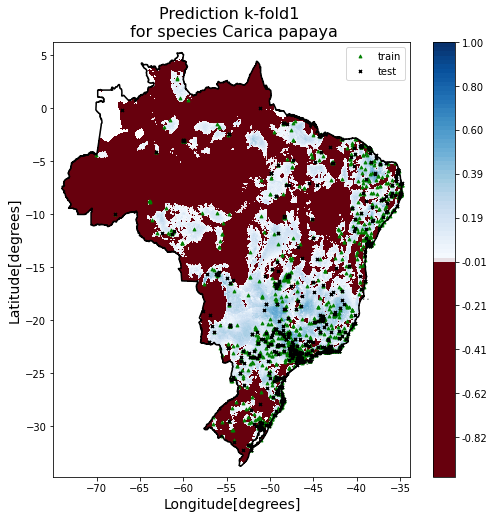

<Figure size 432x288 with 0 Axes>

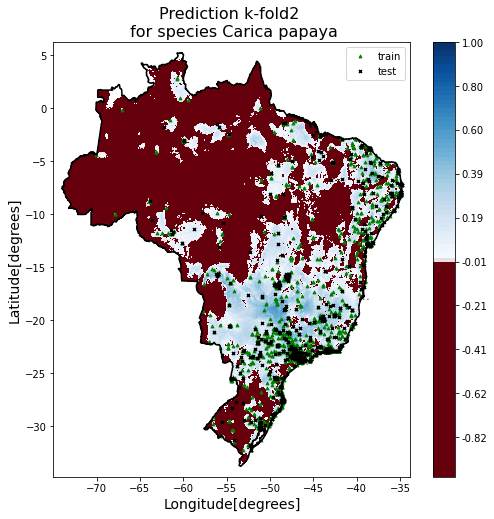

<Figure size 432x288 with 0 Axes>

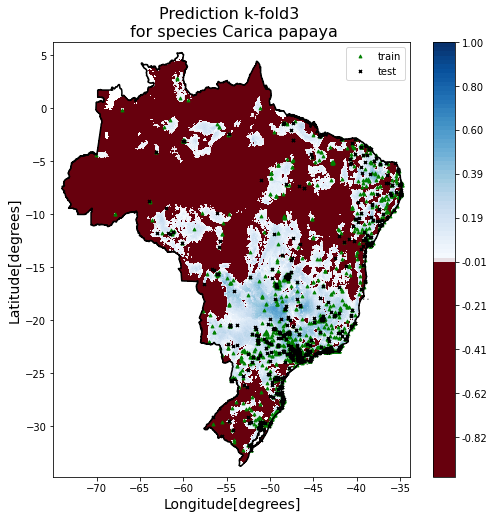

<Figure size 432x288 with 0 Axes>

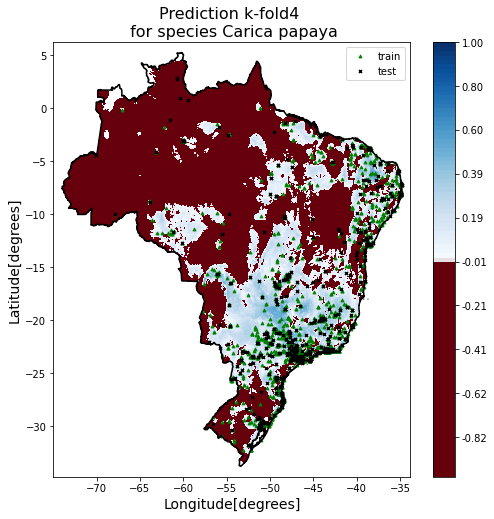

<Figure size 432x288 with 0 Axes>

In [ ]:
if not collect_all:
  saving_kfold_result_maps(species_name=species_name,
                          species_kfold_preditions_folder=species_kfold_preditions_folder,
                          utils_methods=utils_methods,
                          raster_utils=raster_utils,
                          output_folder=species_result_analytics_folder,
                          country_mask_reference=country_mask_reference,
                          n_levels=n_levels)

### Train Data Histogram

In [ ]:
def saving_kfold_train_env_var_histograms(species_name,
                                          species_kfold_preditions_folder,
                                          utils_methods,
                                          output_folder,
                                          base_txt_files_path):
  kfold_dirs = [os.path.join(species_kfold_preditions_folder,name) for name in os.listdir(species_kfold_preditions_folder) if os.path.isdir(os.path.join(species_kfold_preditions_folder,name))]
  for i,fold in enumerate(kfold_dirs):
      env_data_train = utils_methods.retrieve_data_from_np_array(os.path.join(fold,"Species_Raster_Data_Train.npy"))#(N,38)
      list_names_raster = open(f'{base_txt_files_path}/list_names_raster.txt', 'r').read().splitlines()
      env_data_train_df = pd.DataFrame(env_data_train,columns=list_names_raster)
      env_data_train_df.hist(layout=(10,4),figsize=(20,20))
      plt.suptitle(f"Variáveis ambientais não escaladas para as espécie {species_name} kfold{i+1}",fontsize = 20)
      plt.tight_layout()
      plt.subplots_adjust(top=0.95)
      plt.savefig(f'{output_folder}/train_input_vars_unscaled_kfold{i+1}.png')
      plt.show()
      plt.clf()

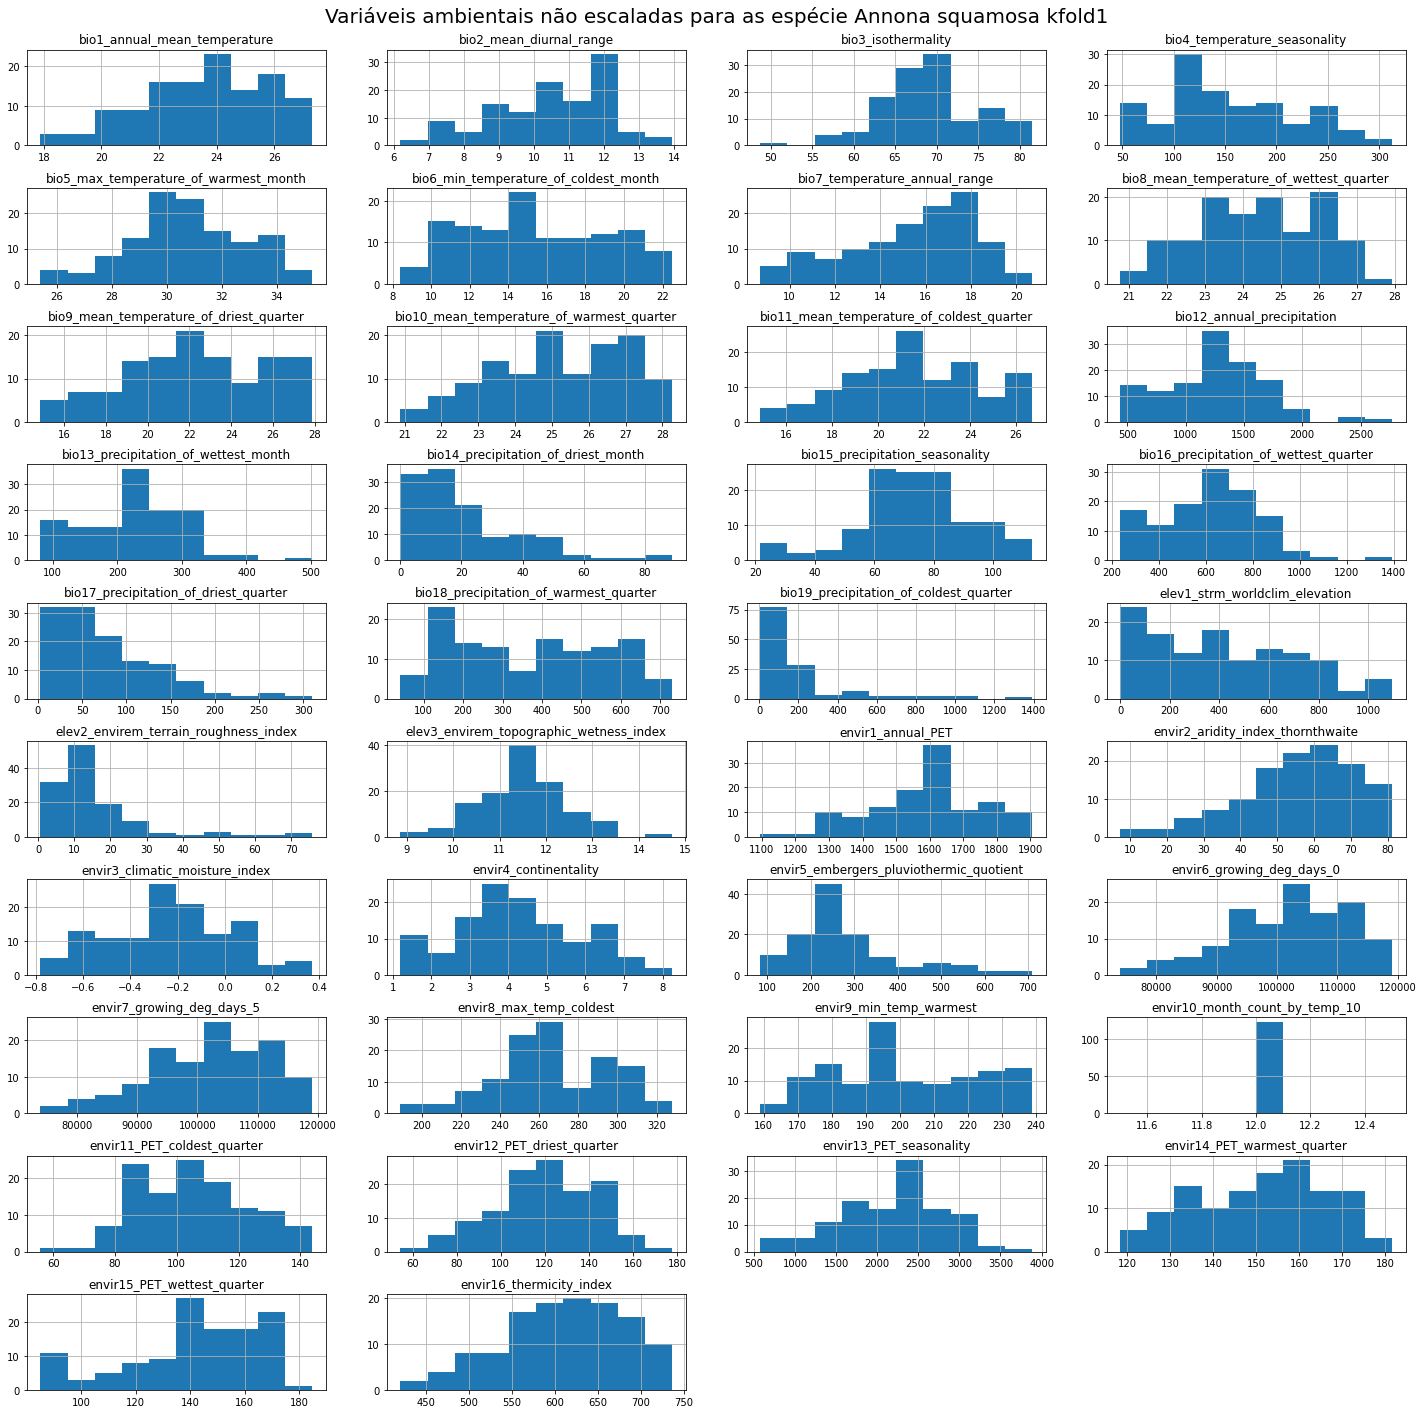

<Figure size 432x288 with 0 Axes>

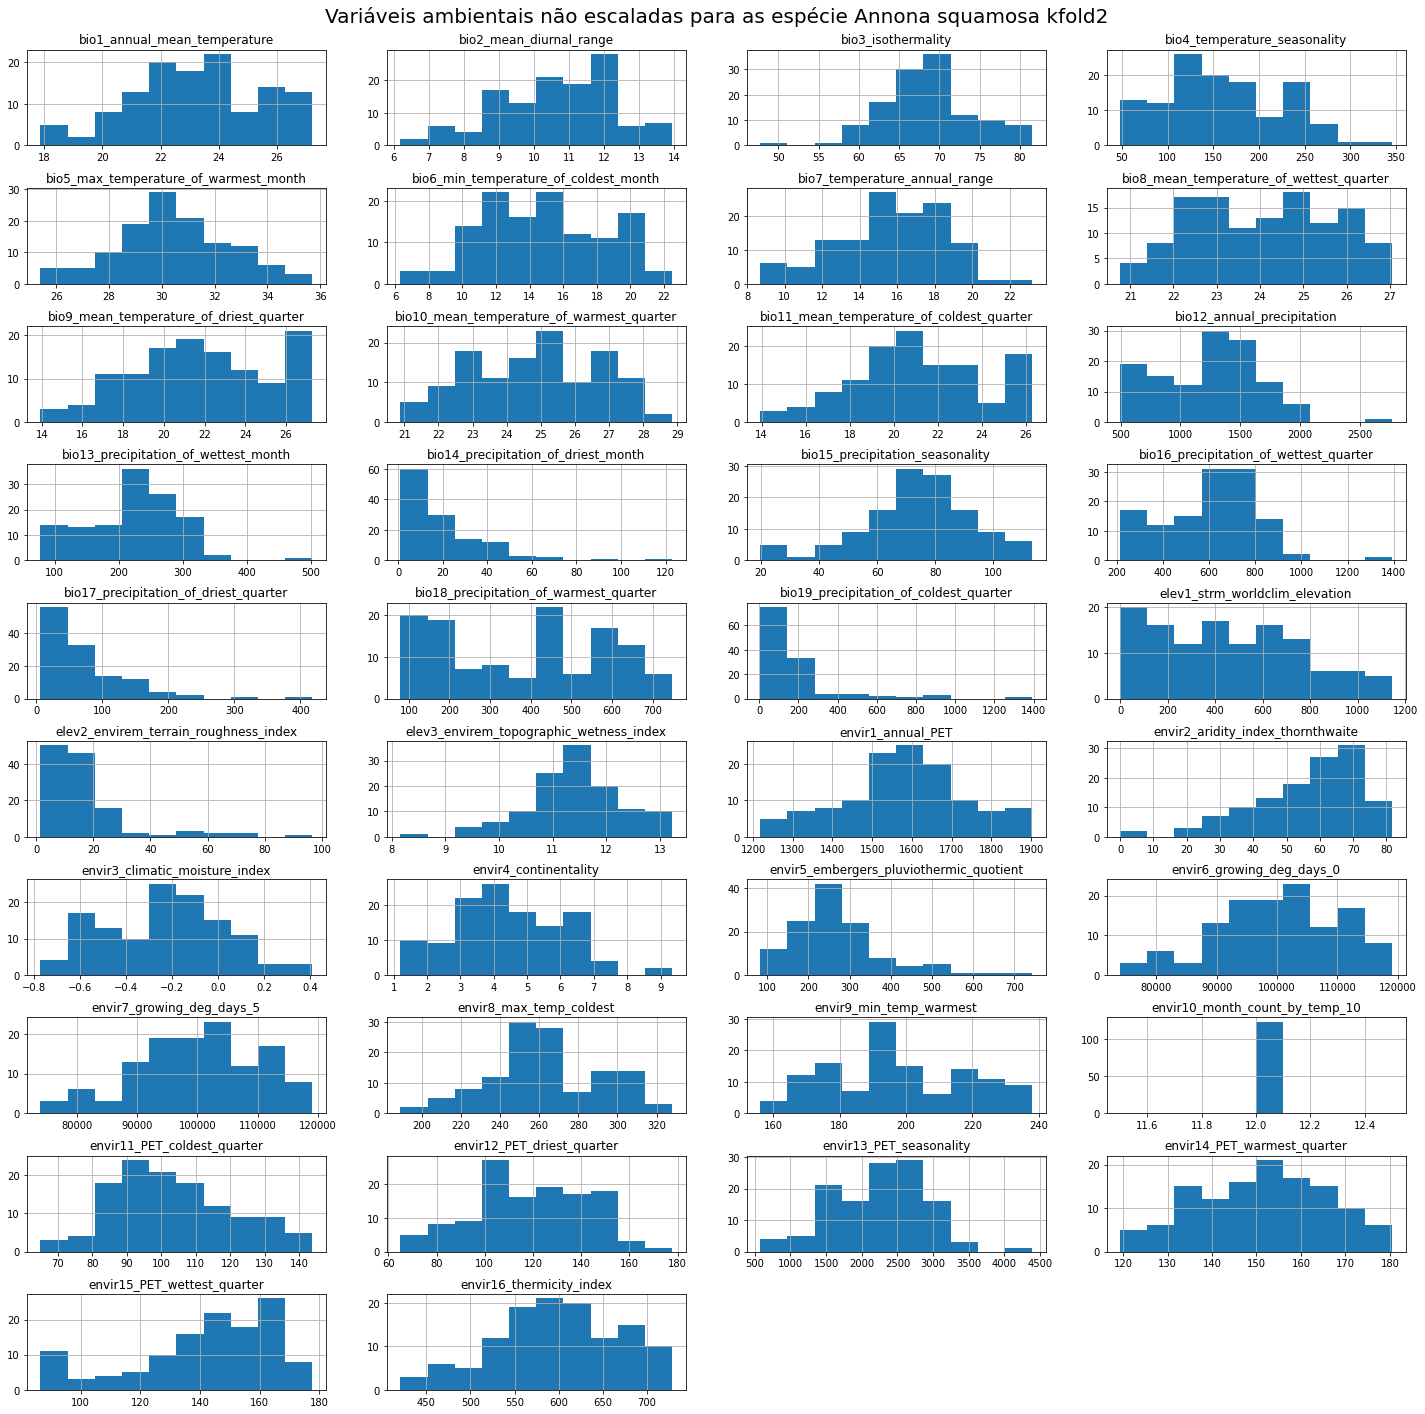

<Figure size 432x288 with 0 Axes>

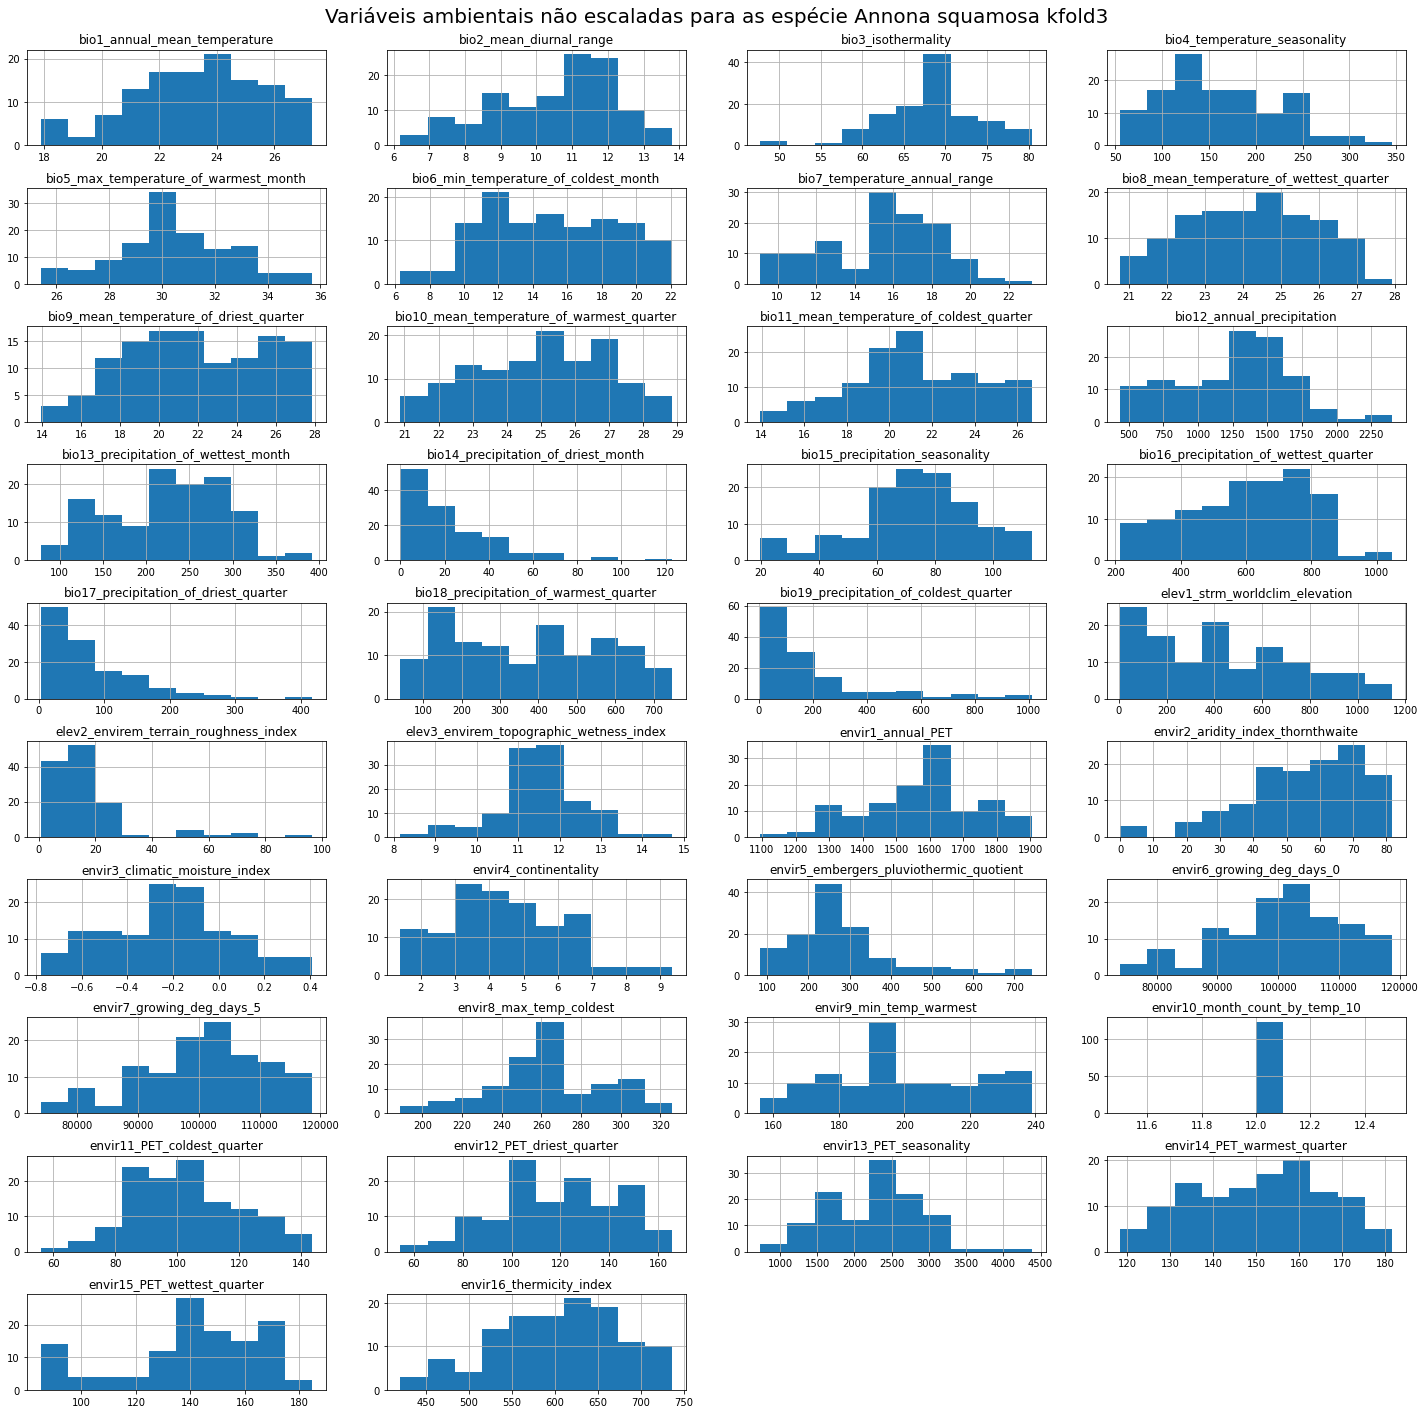

<Figure size 432x288 with 0 Axes>

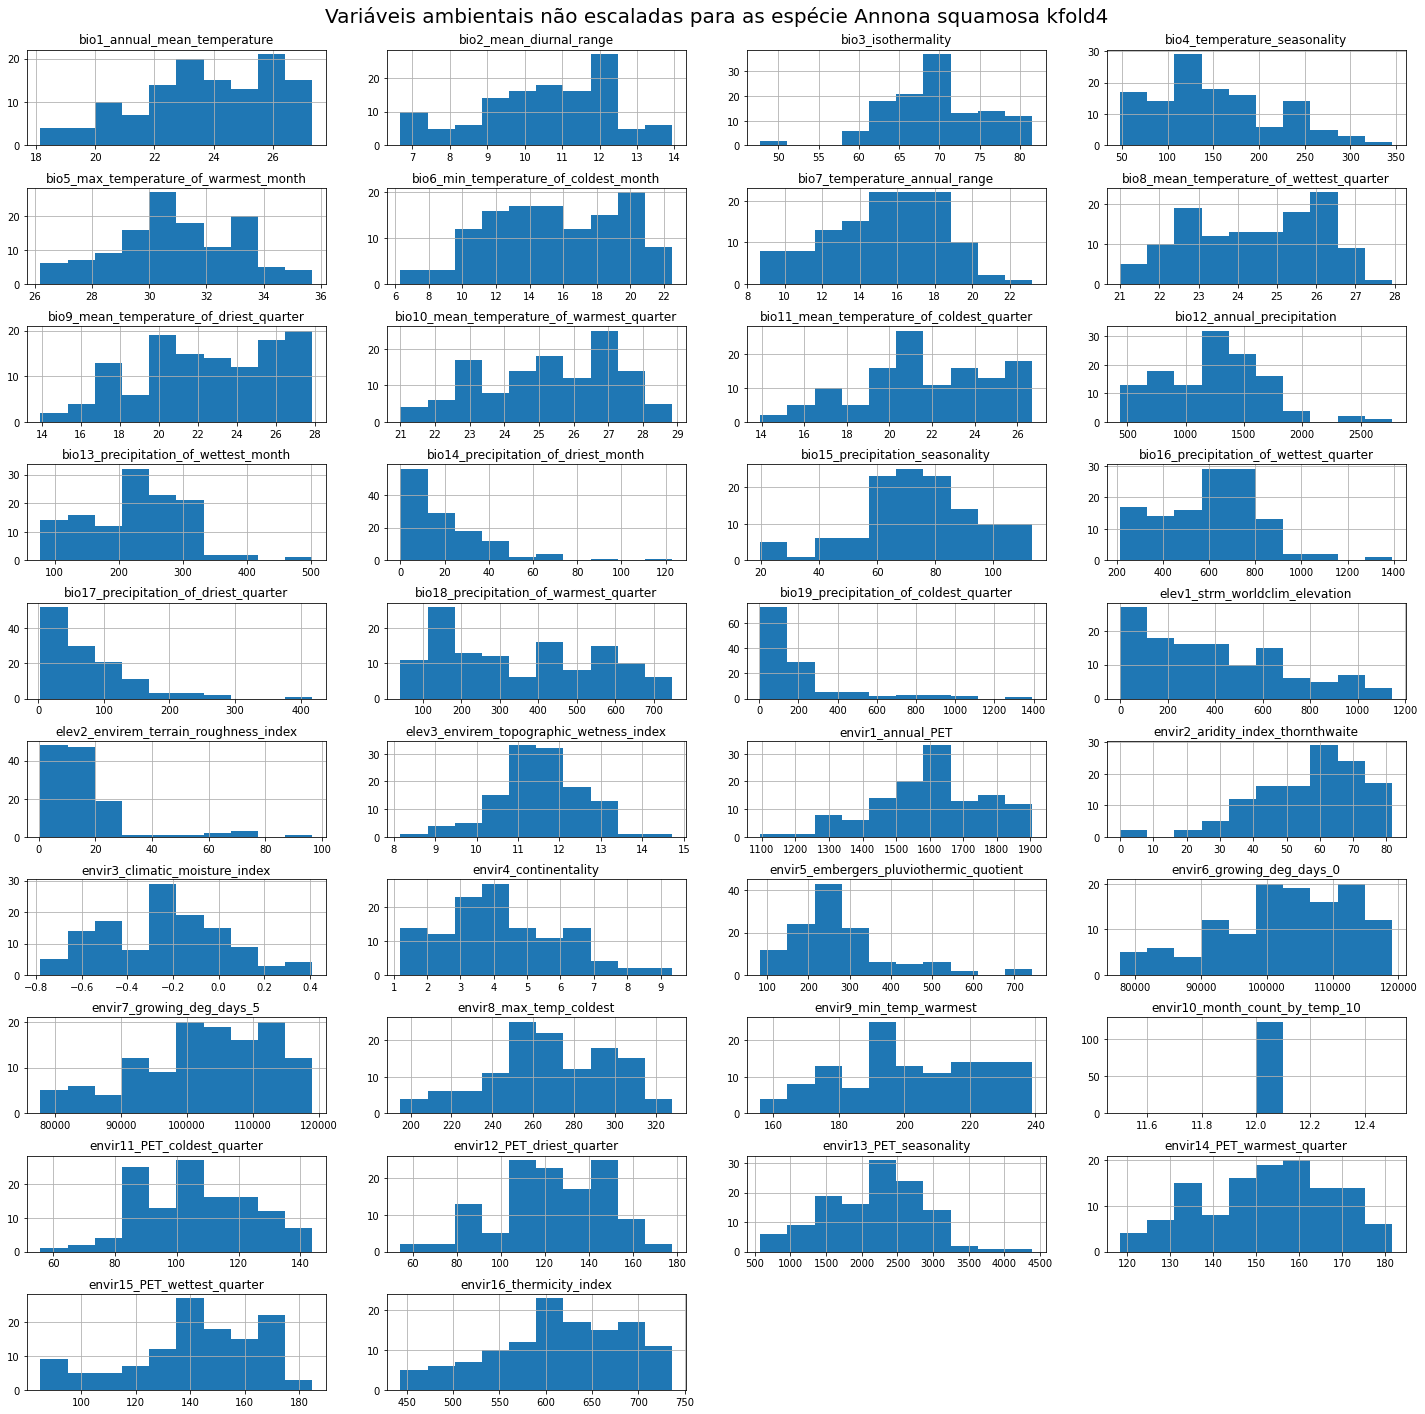

<Figure size 432x288 with 0 Axes>

In [ ]:
if not collect_all:
  saving_kfold_train_env_var_histograms(species_name=species_name,
                                      species_kfold_preditions_folder=species_kfold_preditions_folder,
                                      utils_methods=utils_methods,
                                      output_folder=species_result_analytics_folder,
                                      base_txt_files_path=base_txt_files_path)

### Kernel Distance Histogram

Function to save resulted histograms

In [ ]:
def saving_kfold_result_histograms(species_name,
                                   species_kfold_preditions_folder,
                                   utils_methods,
                                   output_folder,
                                   histogram_granulation):
  # kfold_preditions_folder_root = "/".join(species_kfold_preditions_folder.split("/")[:-1])
  kfold_dirs = [os.path.join(species_kfold_preditions_folder,name) for name in os.listdir(species_kfold_preditions_folder) if os.path.isdir(os.path.join(species_kfold_preditions_folder,name))]


  # idx_X  = utils_methods.retrieve_data_from_np_array(os.path.join(fold,"Idx_X_Brazilian_Territory.npy"))
  # idx_Y  = utils_methods.retrieve_data_from_np_array(os.path.join(fold,"Idx_Y_Brazilian_Territory.npy"))

  for i,fold in enumerate(kfold_dirs):
      plt.figure(figsize=(8,8))
      Z  = utils_methods.retrieve_data_from_np_array(os.path.join(fold,"Land_Prediction.npy"))
      Z_flatten = Z.flatten()
      Z_flatten = Z_flatten[Z_flatten != -9999.0]
      #plotting Histogram
      plt.title(f'Histograma do resultado para\nespécie {species_name} no KFold{i+1}',fontsize=20)
      plt.ylabel('Fequência no mapa',fontsize=18)
      plt.xlabel('Distância ao centróide do Kernel',fontsize=18)
      plt.hist(Z_flatten, bins =histogram_granulation)
      utils_methods.create_folder_structure(output_folder)
      plt.savefig(f'{output_folder}/land_histogram_prediction_kfold{i+1}.png')
      plt.show()
      plt.clf()

Saving and plotting result histograms

> <ipython-input-14-6f55804356ec>(18)saving_kfold_result_histograms()
-> Z_flatten = Z_flatten[Z_flatten != -9999.0]
(Pdb) Z_flatten 
array([-9999., -9999., -9999., ..., -9999., -9999., -9999.], dtype=float32)
(Pdb) np.unique(Z_flatten )
array([-9.9990000e+03, -2.6719156e-01, -2.6719153e-01, ...,
        8.0087177e-02,  8.2064129e-02,  8.6026892e-02], dtype=float32)
(Pdb) Zx
*** NameError: name 'Zx' is not defined
(Pdb) Zx = Z_flatten[Z_flatten != -9999.0]
(Pdb) Zx
array([-0.2671613 , -0.26718208, -0.26716542, ..., -0.2671914 ,
       -0.26718628, -0.26719138], dtype=float32)
(Pdb) c


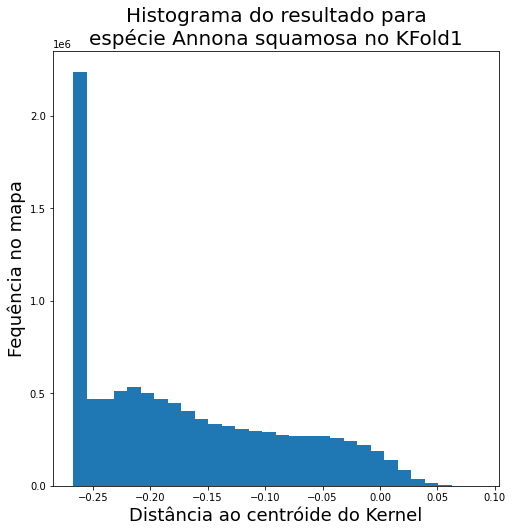

> <ipython-input-14-6f55804356ec>(17)saving_kfold_result_histograms()
-> import pdb;pdb.set_trace()
(Pdb) c


<Figure size 432x288 with 0 Axes>

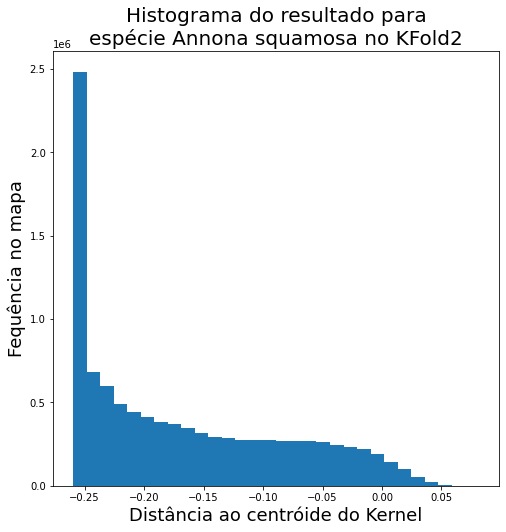

> <ipython-input-14-6f55804356ec>(18)saving_kfold_result_histograms()
-> Z_flatten = Z_flatten[Z_flatten != -9999.0]
(Pdb) c


<Figure size 432x288 with 0 Axes>

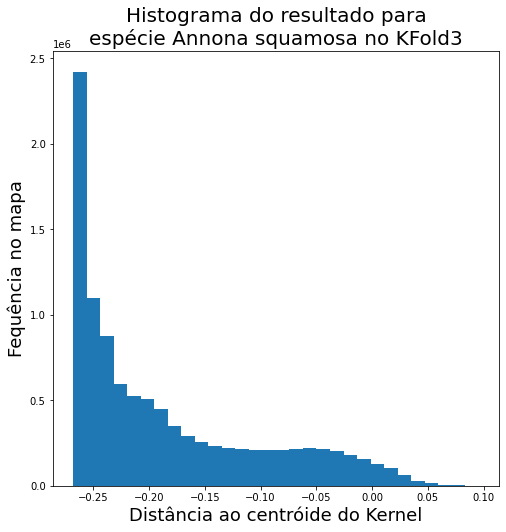

> <ipython-input-14-6f55804356ec>(17)saving_kfold_result_histograms()
-> import pdb;pdb.set_trace()
(Pdb) c


<Figure size 432x288 with 0 Axes>

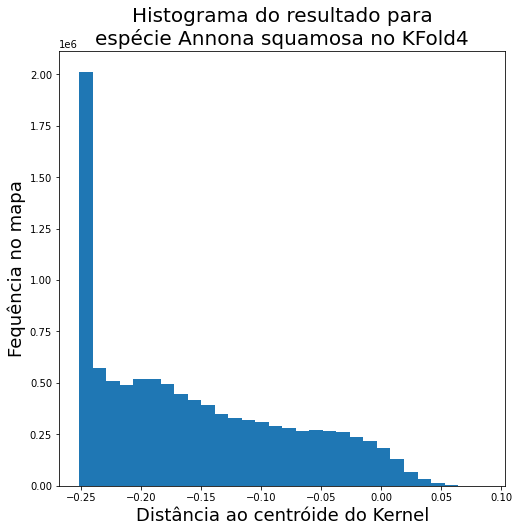

<Figure size 432x288 with 0 Axes>

In [ ]:
if not collect_all:
  saving_kfold_result_histograms(species_name=species_name,
                               species_kfold_preditions_folder=species_kfold_preditions_folder,
                               utils_methods=utils_methods,
                               output_folder=species_result_analytics_folder,
                               histogram_granulation =histogram_granulation)

## K Fold Roc Curve

Only necessary to activate plotly

In [ ]:
def activate_plotly():
  fig = {"data": [{"y": [1,2,1]}]}
  call(['orca', 'graph', json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)])

Plot kfold ROC curve

In [ ]:
def compute_roc_curve(species_name,
                      species_kfold_preditions_folder,
                      species_result_analytics_folder,
                      utils_methods,
                      country_mask_reference,
                      raster_utils,
                      seed):
  np.random.seed(seed)
  reference_array,_,_,_,_,_ = raster_utils.get_raster_infos(country_mask_reference)
  kfold_dirs = [os.path.join(species_kfold_preditions_folder,name) for name in os.listdir(species_kfold_preditions_folder) if os.path.isdir(os.path.join(species_kfold_preditions_folder,name))]
  fig = go.Figure()
  fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
  roc_auc_list = []
  for i,fold in enumerate(kfold_dirs):
    background_points = np.c_[np.random.randint(low=0, high=reference_array.shape[0],size=100000),np.random.randint(low=0, high=reference_array.shape[1], size=100000)].T
    Z  = utils_methods.retrieve_data_from_np_array(os.path.join(fold,"Land_Prediction.npy"))
    pred_background = Z[background_points[0], background_points[1]]
    pred_test = utils_methods.retrieve_data_from_np_array(os.path.join(fold,"Test_Prediction.npy"))
    y_score = np.r_[pred_test, pred_background]
    y_true = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_list.append(roc_auc)
    
    name = f"KFold{i+1} => (AUC={roc_auc})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

  roc_auc_mean = np.mean(roc_auc_list)
  fig.update_layout(
    title=go.layout.Title(text=f"ROC curve and AUC metric for each {species_name} k-fold.\nMean AUC :{roc_auc_mean}"),
    xaxis_title='Specificity',
    yaxis_title='Sensitivity',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700,
    height=500,
    font=dict(
        family="sans serif",
        size=14
    ))
  
  fig.show()
  fig.write_image(f'{species_result_analytics_folder}/roc_and_auc_kfold.png')



In [ ]:
if not collect_all:
  activate_plotly()
  compute_roc_curve(species_name=species_name,
                    species_kfold_preditions_folder=species_kfold_preditions_folder,
                    species_result_analytics_folder = species_result_analytics_folder,
                    utils_methods=utils_methods,
                    country_mask_reference=country_mask_reference,
                    raster_utils=raster_utils,
                    seed=seed)

Reading raster brazilian_mask_standarized.tif


## Executing pipeline step for all studied species

In [ ]:
if collect_all:
  for tax_id, species_name in species_taxon_id_dict.items():
    print(f">>>>>>>>>> Generating results for : {species_name} <<<<<<<<<<<\n")
    
    #Results sub folders creation
    species_kfold_preditions_folder = os.path.join(kfold_predictions_root_folder,species_name)
    species_result_analytics_folder = os.path.join(result_analytics_root_folder,species_name)

    #Function calling
    saving_kfold_result_maps(species_name=species_name,
                              species_kfold_preditions_folder=species_kfold_preditions_folder,
                              utils_methods=utils_methods,
                              raster_utils=raster_utils,
                              output_folder=species_result_analytics_folder,
                              country_mask_reference=country_mask_reference,
                              n_levels=n_levels)

    saving_kfold_train_env_var_histograms(species_name=species_name,
                                      species_kfold_preditions_folder=species_kfold_preditions_folder,
                                      utils_methods=utils_methods,
                                      output_folder=species_result_analytics_folder,
                                      base_txt_files_path=base_txt_files_path)
    
    saving_kfold_result_histograms(species_name=species_name,
                                   species_kfold_preditions_folder=species_kfold_preditions_folder,
                                    utils_methods=utils_methods,
                                    output_folder=species_result_analytics_folder,
                                    histogram_granulation =histogram_granulation)
    activate_plotly()
    compute_roc_curve(species_name=species_name,
                      species_kfold_preditions_folder=species_kfold_preditions_folder,
                      species_result_analytics_folder = species_result_analytics_folder,
                      utils_methods=utils_methods,
                      country_mask_reference=country_mask_reference,
                      raster_utils=raster_utils,
                      seed=seed)